<H1>Quantum Erasure</H1> 
A polarization based model with 'delayed' detection. <br> 
This is interesting in a number of ways for exploring entanglement, and in specific how does
quantum error correction work. 
<hr>
<H2>Modification history </H2><br> 
<table>
    <tr>
        <th> Modified </th>
        <th> By </th>
        <th> Reason </th>
    </tr>
    <tr> 
        <td> 07-Apr-25 </td>
        <td> CBL </td> 
        <td> Original </td>
    </tr>
    <tr> 
        <td> 09-Apr-25 </td>
        <td> CBL </td> 
        <td> Took out class def </td>
    </tr>
    <tr> 
        <td> 24-Jul-25 </td>
        <td> CBL </td> 
        <td> V1.1 Using Qiskit AER specifically called out (simulation) and using estimtator to get expectation values. V1.2 trying to vary phi as well. </td>
    </tr>
</table>
<hr> 
<H2> References </H2> 
<a href="https://docs.quantum.ibm.com/guides/install-qiskit"> Install Qikit </a> <br> 
<a href="https://docs.quantum.ibm.com/guides/hello-world"> qiskit hello world </a> <br> 
<a href="https://qiskit-community.github.io/qiskit-dynamics/"> Qiskit dynamics</a> <br> 
<a href="https://pypi.org/project/qiskit/"> Pypi qiskit page</a> <br> 
<a href="https://docs.quantum.ibm.com/api/qiskit/visualization"> Visualization</a> <br> 
<hr>
<H2> Notes </H2>
Based on paper Demonstration of Scully-Druhl-type quantum erasers on quantum computers, arXiv: 2409.08053v2
<br> 
<hr>

In [1]:
# my standard includes
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.constants as const
# Qiskit includes
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter, Delay
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Pauli
from scipy.spatial.transform import Rotation as R
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2
from matplotlib import cm

<H1> Discussion </H1>
The experiment we are trying to reproduce is given by the following figure. <br> 
<figure>
  <img src="Pics/Picture1.png">
  <figcaption>Quantum erasure with delayed measurement using polarization.</figcaption>
</figure>
The signal path will be qubit 0 and the idler will be qubit 1. <br> 
I will encode polarization into the state of the signal qubit. The position on the Bloch sphere 
can represent the polarization. <br> 
The phase should not be necessary, since this is a single object and overall the system should be 
tuned for the proper interference. I'll add it anyway and perform a sweep to show how the pattern
changes in the detectors. <br> 
The detectors can be mapped in terms of looking at a histogram of the projection of the final state
into either $\ket{0}$ or $\ket{1}$. When in balance, it should be 50:50.
<hr> 
As I go through the program exercising the cells, I'll do intermediate tests on the circuit to
make sure it is working correctly. Without doing a delayed measurement on the idler qubit, the 
overall system should replicate any double slit like experiment. 
<H2> Discussion on delayed measurement. </H2>
The signal photon is sent through a polarizing beam splitter (PBS) and given a polarization. Note
that a variable polarizer is introduced in the upper branch of the Mach-Zender interferometer.  This effectively measures the polarization induced by the PBS. Performing a measurement should collapse the interference pattern. 

The idler photon is sent along a delayed path. At the end in the picture it goes through the Wollastone Prism which creates two paths of different polarizations. <br> 
<a href="https://en.wikipedia.org/wiki/Wollaston_prism"> Wollastone Prism </a> <br>
The idea in the erasure experiment that the delayed measurement of the polarization should have 
a similar effect. 

<H2> Implementation</H2>
Like with the Two Slit experiment, we will use one qubit as the tool for the Mach-Zender 
interferometry and use the phase on the Bloch sphere to represent the polarization. 

A second qubit is introduced to simulate the idler photon and a CNOT gate is performed after the Hadamard gate to effectively entangle the pair. The resulting measurement is delayed. 

Code description: 
<ul>
    <li> nqbit - number of qubits needed to run the experiment. </li>
    <li> ncbit - number of classical bits needed - this is a register to put the results in. </li>
    <li> creg - a classical register to collect the results. </li>
    <li> qreg - the register of quantum bits that will be run on a simulator or back end. </li>
    <li> nshots - number of measurements to be made per point or number of times to perform the experiment. </li>
    <li> qc - The quantum circuit. </li>
    <li> sampler - permits the system to know that we want to run this circiut multiple times and collect the results. (gives a lot of information to runtime.)</li>
</ul>

<hr> 
This program does not work since state sampler does not deal with mid measurement results. This feature is still in the notebook and can be used as a test point, but
the delayed results need to be done in a loop. 
<hr>
<H1> Notes! </H1>
If you are not familiar with Jupyter notebooks there are some interesting features that can be exploited or can cause you issues. I have purposely put the program into separate cells. You can execute the cells in order to get the desired result. If there is a mistake in a cell, you can fix it and re-execute it. The previous definitions will be overwritten. HOWEVER! it is possible to have old variables that you didn't want floating around that give anomolous results, be careful. 
<hr>

In [2]:
# Inializize the system
# instantiate the AER simulator
# with an account, you can specify a backend error model based off of one of the IBM systems if desired.
# 
sim = AerSimulator()
#
# Define the number of quantum bits. For this problem (double slit) we can use a single qubit and use
# the superposition to calculate the phase of the complete system. 
nqbits = 2
# define the clasical bits to store the output data
ncbits = 2
# This is the value I'll use for the delayed measurement. these are somewhat arbitray values. 
dt  = 100        # in units of dt, need to ask about this, pretty sure this is handled in the RTE. 
# Make a classical bit register, this is really an artifact of qiskit. This is where the results end up. 
creg = ClassicalRegister(ncbits, 'cbit')
# Define the qubits we want. this is where the qubits originate. 
qreg = QuantumRegister(nqbits)
# Create a quantum circuit class with these registers. 
# Reference on usage: https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.QuantumCircuit
#
qc = QuantumCircuit(qreg, creg)
#
# Create an estimator - this gives the expectation value of each system. 
# the number of shots is the number of times that the experiment is replicated to produce statistics. 
# In the estimator, you specify the precision instead, this is the default and can be overriden in 
# the estimator run command. Default precision is 0
estimator = EstimatorV2()

<H1> Define Signal Path</H1>
We will use qubit 0 two represent the signal path in the figure. Steps:
<ul>
    <li> Initialize qubit 0</li>
    <li> Apply a Hadamard gate to create a superposition in the qubit. Effectively createing two path like in the M-Z interferometer. ${{\ket{0}+\ket{1}}\over{\sqrt{2}}}$</li>
    <li> Introduce a phase on the qubit, this is the equivalent of creating a path length difference or can be used as an encoding technique other than using polarization. In this case it will repesent the polarization.  </li>
    <li> do a Hadamard again - representing the combination of the two potential paths. </li>
    <li> measure the outcome. </li>
</ul>
The outcomes will be in the form of a number of times it measured zero and the number of times it measured one. The total should equal the value of nshots. The probability will be the number divided by the number of shots for each. 
<br>
<a href="https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.PhaseGate"> Phase Gate Reference </a>

In [3]:
# Create the signal path
# reference: https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.Initialize
# comment out the CNOT for debugging purposes
qc.initialize(0,0,0)
# define the signal path, use a phase encoding rather than a polarizer. 
# Apply a hadamard on qubit 0 (signal) - this creates equal path case, superposition
# The Hadamard gate can also be expressed as a 90º rotation around the Y-axis, followed by a 180º around the X-axis. 
# This represents the beam splitter
qc.h(0)
# Apply a CNOT (entangling gate) between the signal and idler qubits. 
# Perform a controlled not (CNOT) on qubit 1, controlled by qubit 0
qc.cx(0,1)
# Now lets add all the components in the signal path. 
# introduce a phase - change the path length. https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.PhaseGate
# This is a rotation around the z axis. This is the variable a
# This represents the polarizer. 
qc.p(Parameter('a'), 0)
# recombine the paths, the beamsplitter. 
qc.h(0)
# we are ready with the signal path. 
# Do the measurement on the signal qubit now!!
qc_measured = qc.measure(0, 0)

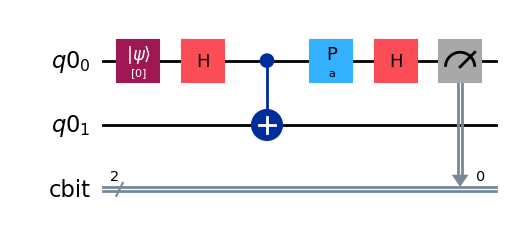

In [4]:
# Draw the initial circuit for verification. 
qc.draw('mpl')

At this point we have not introduced the idler path. This is identical to the double slit or Mach-Zender interferometer experiment. 
Lets run the circuit to verify that. 

Text(0, 0.5, 'intensity')

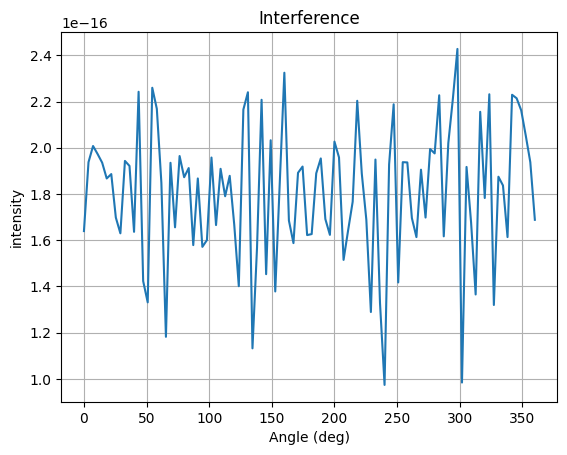

In [5]:
# Vary the parameter a from 0 to 2*pi, 100 points
theta = np.linspace(0., 2*np.pi, 100)
#
observables = [SparsePauliOp("ZZ")]
pub   = (qc, observables, theta)
# Run the job
job = estimator.run([pub])
# get the results
result = job.result()[0] # only single job from pub. 
x = 180.0/np.pi * theta
y = result.data.evs
plt.plot(x,y)
plt.grid()
plt.title('Interference')
plt.xlabel('Angle (deg)')
plt.ylabel('intensity')

In [6]:
# finalize the idler path
"""
Define the idler path. 
The delay insures that we post measure our result. 
"""
# create a range of phi to use. 
phi   = [0.0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2, np.pi]
qc.barrier()
qc.delay(dt)
# add in rotation around y on qubit 1 - This introduces a change to determine which way. 
# come back and change to variable 
#qc.ry(phi[5], 1)
qc.ry(Parameter('b'),1)
# Measure result and store in classical register 1
qc_measured = qc.measure(1, 1)

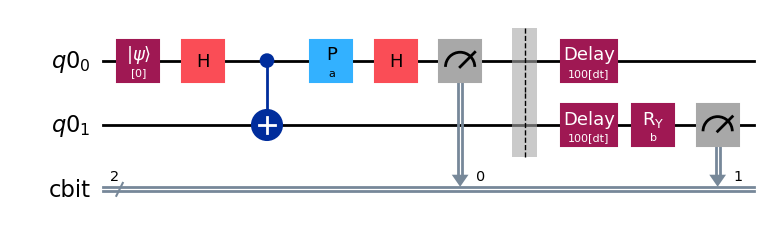

In [7]:
qc.draw('mpl')

Run the circuit. 

In [8]:
# Setup the job to sweep the value of a
# This is a joint measurement. 
observables = [SparsePauliOp("ZZ")]
#
# Multiple pubs 
# https://quantum.cloud.ibm.com/docs/en/guides/primitive-input-output
#
# theta varies the phase in the primary circuit. 
theta  = np.linspace(0., 2*np.pi, 100)
# phi varies Ry in the 'which way' detector. 
#phi   = [0.0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2, np.pi]
#phi = [0.0, 0.0]
# 
# create a matrix of parameters to pass in to the estimator run. 
# There is probably a better way to do this. 
#
params = np.zeros((len(theta)*len(phi),2),dtype=float)
i = 0
for th in theta:
    for ph in phi:
        params[i,0] = th
        params[i,1] = ph
        i = i+1
#params = [phi[0], theta]
pub   = (qc, observables, params)
# Run the job
job = estimator.run([pub])
# get the results
result = job.result()[0] # only single job from pub. 
# reshape the resulting data. 
y = result.data.evs
z = y.reshape(len(phi),len(theta), order='F')

Text(0, 0.5, 'intensity')

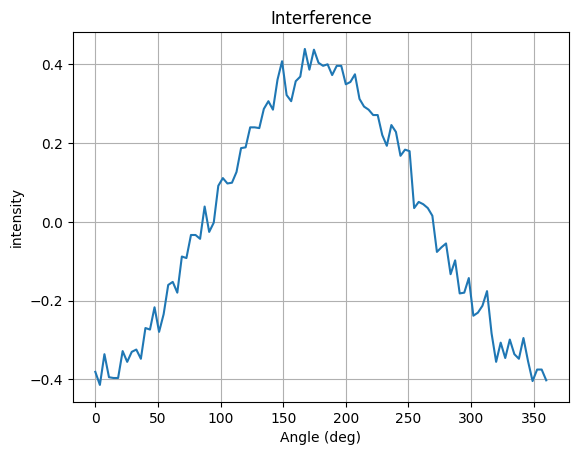

In [9]:
index = 1
x = 180.0/np.pi * theta
plt.plot(x,z[index,:])
plt.grid()
plt.title('Interference')
plt.xlabel('Angle (deg)')
plt.ylabel('intensity')

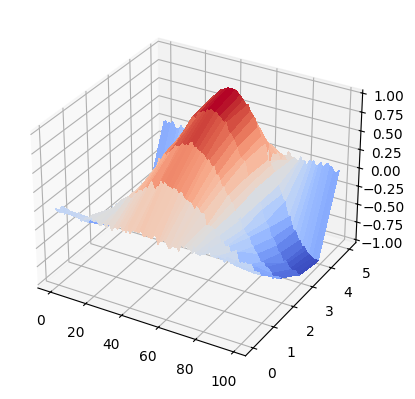

In [10]:
# Prepare X and Y coordinates
x_coords = np.arange(z.shape[1])
y_coords = np.arange(z.shape[0])
X, Y = np.meshgrid(x_coords, y_coords)
#
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


You can see that the fringe changes as the delayed measurement changes. 

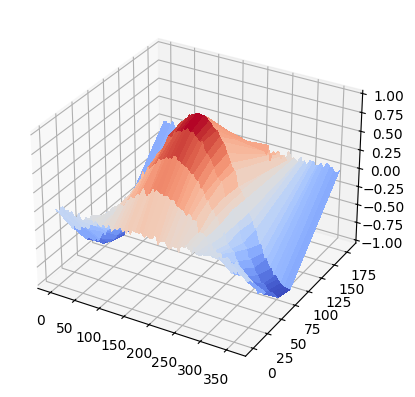

In [12]:
# Prepare X and Y coordinates
phi2 = 180.0/np.pi*np.array(theta)
theta2 = 180.0/np.pi*np.array(phi)
X, Y = np.meshgrid(phi2, theta2)
#
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


In [16]:
phi

[0.0,
 0.39269908169872414,
 0.7853981633974483,
 1.1780972450961724,
 1.5707963267948966,
 3.141592653589793]